# Hardware efficient ansatz

In [78]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

import numpy as np
import pprint

from qiskit import Aer
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.aqua.components.optimizers import SLSQP, COBYLA, CG
from qiskit.chemistry import QiskitChemistryError
from qiskit.chemistry.applications import MolecularGroundStateEnergy
from qiskit.chemistry.algorithms import ground_state_solvers
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.core import QubitMappingType, Hamiltonian, TransformationType
from qiskit.chemistry.drivers import PySCFDriver, UnitsType, HFMethodType
from qiskit.circuit.library import TwoLocal
from qiskit.tools.visualization import circuit_drawer

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit import IBMQ
provider = IBMQ.load_account()

from qiskit.aqua.components.variational_forms import VariationalForm

ibmqfactory.load_account:WARNING:1970-01-02 04:38:41,067: Credentials are already in use. The existing account in the session will be replaced.


### Definizione dell'ansatz SO(4)

* La classe SO_04 funziona solo per 4 qubit, dovrei generalizzarla

In [80]:
def add_unitary_gate(circuit,qubit1,qubit2,params,p0):
    circuit.s(qubit1)
    circuit.s(qubit2)
    circuit.h(qubit2)
    circuit.cx(qubit2,qubit1)
    circuit.u3(params[p0],params[p0+1],params[p0+2],qubit1); p0 += 3
    circuit.u3(params[p0],params[p0+1],params[p0+2],qubit2); p0 += 3
    circuit.cx(qubit2,qubit1)
    circuit.h(qubit2)
    circuit.sdg(qubit1)
    circuit.sdg(qubit2) 

In [81]:
class SO_04(VariationalForm):
    
    def __init__(self, numqubits):
        self._num_qubits = numqubits
        self._num_parameters = 6*(numqubits-1)
               
    def construct_circuit(self, parameters):
        q = QuantumRegister(self._num_qubits, name='q')
        circ = QuantumCircuit(q)
        
        #initial state       
        circ.x(0)
        circ.x(1)
  
        if self._num_qubits == 4:        
            add_unitary_gate(circ, 0, 1, parameters, 0)
            add_unitary_gate(circ, 2, 3, parameters, 6)
            add_unitary_gate(circ, 1, 2, parameters, 12)
            
        return circ
    
    @property
    def num_parameters(self):
        return self._num_parameters    

In [92]:
def vqe_function(geometry, basis = 'sto-6g', var_form_type = 'TwoLocal(ry)', 
                 quantum_instance = Aer.get_backend("statevector_simulator")):
    
    optimizer = CG(maxiter=1000)
    
    two_qubit_reduction = True
    qubit_mapping = 'parity'
    
    charge = 1
    spin = 0
    driver = PySCFDriver(atom = geometry,
                         unit=UnitsType.ANGSTROM, spin = spin,
                         charge=charge, basis=basis,hf_method=HFMethodType.RHF)
    
    molecule = driver.run()
    
    shift = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_orbitals = molecule.num_orbitals
    num_spin_orbitals = num_orbitals*2
    
    
    core = Hamiltonian(transformation=TransformationType.FULL, qubit_mapping=QubitMappingType.PARITY, 
                   two_qubit_reduction=two_qubit_reduction, freeze_core=False)

    qubitOp, aux_ops = core.run(molecule)
    
    initial_state = HartreeFock(num_spin_orbitals, 
                                num_particles, 
                                qubit_mapping,
                                two_qubit_reduction)
 
    var_form = TwoLocal() #dummy
    
    if var_form_type == 'TwoLocal(ry)':
        var_form = TwoLocal(rotation_blocks=['ry'], entanglement_blocks='cz',
                            num_qubits=4,
                            initial_state=initial_state,
                            entanglement='linear')
        
    if var_form_type == 'TwoLocal(ry_rz)':
        var_form = TwoLocal(rotation_blocks=['ry','rz'], entanglement_blocks='cz',
                            num_qubits=4,
                            initial_state=initial_state,
                            entanglement='linear')
    
    if var_form_type == 'UCCSD':
        var_form = UCCSD(num_orbitals=num_spin_orbitals,
                        num_particles=num_particles,
                        initial_state=initial_state,
                        qubit_mapping=qubit_mapping,
                        two_qubit_reduction=two_qubit_reduction,
                        z2_symmetries=None)
        
    if var_form_type == 'SO(4)':
        var_form = SO_04(4)
    
    init_parm = np.zeros(var_form.num_parameters)    
    
    vqe = VQE(qubitOp, var_form, optimizer, initial_point=init_parm)
    vqe_result_tot = vqe.run(quantum_instance, memory=True)
    return np.real(vqe_result_tot['eigenvalue'] + shift) #, var_form

In [74]:
dist = np.arange(0.3, 3.0, 0.1)
#dist = np.arange(3.0, 1.2, -0.1)
alt = np.sqrt(dist**2 - (dist/2)**2)

energies = {}

#energies["UCCSD"] = []
energies["TwoLocal"] = []
energies["SO(4)"] = []

for i in range(len(dist)):
    geometry = "H .0 .0 .0; H .0 .0 " + str(dist[i]) + "; H .0 " + str(alt[i]) + " " + str(dist[i]/2)
    result_two = vqe_function(geometry, var_form_type = "TwoLocal")
    energies["TwoLocal"].append(result_two)
    
    result_so = vqe_function(geometry, var_form_type = "SO(4)")
    energies["SO(4)"].append(result_so)
    
    #result_ucc = vqe_function(geometry, var_form_type = "UCCSD")
    #energies["UCCSD"].append(result_ucc)
    
    print("Distanza ",dist[i], "\t TwoLocal: ", result_two, "\t SO(4): ", result_so) #, "\t UCCSD: ", result_ucc)    
    

Distanza  0.3 	 TwoLocal:  0.8056100703877425 	 SO(4):  0.8056100703877425
Distanza  0.4 	 TwoLocal:  -0.22321436431273156 	 SO(4):  -0.22321436431273156
Distanza  0.5 	 TwoLocal:  -0.7367229629714376 	 SO(4):  -0.7367229629714376
Distanza  0.6000000000000001 	 TwoLocal:  -1.0071045474340536 	 SO(4):  -1.007104547434055
Distanza  0.7000000000000002 	 TwoLocal:  -1.1497856298272189 	 SO(4):  -1.149785629827218
Distanza  0.8000000000000003 	 TwoLocal:  -1.2207206449518255 	 SO(4):  -1.2207206449518206
Distanza  0.9000000000000001 	 TwoLocal:  -1.2494674834990804 	 SO(4):  -1.2494674834990818
Distanza  1.0000000000000002 	 TwoLocal:  -1.2526503411788479 	 SO(4):  -1.2526503411788479
Distanza  1.1000000000000003 	 TwoLocal:  -1.2400693045269688 	 SO(4):  -1.2400693045269693
Distanza  1.2000000000000004 	 TwoLocal:  -1.2177264183217735 	 SO(4):  -1.2177264183217753
Distanza  1.3000000000000005 	 TwoLocal:  -1.1894353848951142 	 SO(4):  -1.1894353848951142
Distanza  1.4000000000000004 	 TwoL

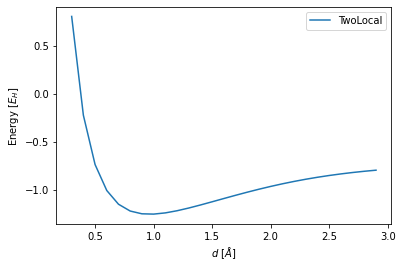

In [27]:
for (method,E) in energies.items():
    plt.plot(dist,E,label=method)
#plt.ylim([-1.3, -1.1])
#plt.xlim([0.5, 1.5])
plt.xlabel(r"$d$ $[\AA]$")
plt.ylabel(r"Energy $[E_H]$")
plt.legend()
plt.savefig('/mnt/c/Users/Rodolfo/Desktop/figura.png')
plt.show()

## Hola! Noise from santiago

In [34]:
backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_santiago")

coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates
seed = 150
aqua_globals.random_seed = seed

quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                    coupling_map=coupling_map, noise_model=noise_model,shots=8000)

dist = np.arange(0.3, 3.5, .1)
alt = np.sqrt(dist**2 - (dist/2)**2)

energies = {}

energies["UCCSD"] = []
energies["TwoLocal(ry)"] = []
energies["TwoLocal(ry_rz)"] = []
energies["SO(4)"] = []

for i in range(len(dist)):
    geometry = "H .0 .0 .0; H .0 .0 " + str(dist[i]) + "; H .0 " + str(alt[i]) + " " + str(dist[i]/2)
    
    result_two_ry = vqe_function(geometry, var_form_type = "TwoLocal(ry)", quantum_instance = quantum_instance)
    energies["TwoLocal(ry)"].append(result_two_ry)
    
    result_two_ry_rz = vqe_function(geometry, var_form_type = "TwoLocal(ry_rz)", quantum_instance = quantum_instance)
    energies["TwoLocal(ry_rz)"].append(result_two_ry_rz)
    
    result_so_4 = vqe_function(geometry, var_form_type = "SO(4)", quantum_instance = quantum_instance)
    energies["SO(4)"].append(result_so_4)
    
    result_ucc = vqe_function(geometry, var_form_type = "UCCSD", quantum_instance = quantum_instance)
    energies["UCCSD"].append(result_ucc)
    
    print("Distanza ",np.round(dist[i],2), 
          "\n\t TwoLocal(ry): ", result_two_ry,
          "\n\t TwoLocal(ry_rz): ", result_two_ry_rz,
          "\n\t SO(4): ", result_so_4,
          "\n\t UCCSD: ", result_ucc)   

Distanza  0.3 
	 TwoLocal(ry):  0.9002834096487531 
	 TwoLocal(ry_rz):  0.9002834096487531 
	 SO(4):  0.9699465549355359 
	 UCCSD:  2.3299966202629703
Distanza  0.4 
	 TwoLocal(ry):  -0.14414207453517758 
	 TwoLocal(ry_rz):  -0.14414207453517758 
	 SO(4):  -0.08654186448546497 
	 UCCSD:  1.057699370454591
Distanza  0.5 
	 TwoLocal(ry):  -0.6710479367759232 
	 TwoLocal(ry_rz):  -0.6711120543009725 
	 SO(4):  -0.6232233382082311 
	 UCCSD:  0.34600895317241376
Distanza  0.6 
	 TwoLocal(ry):  -0.9506421032691996 
	 TwoLocal(ry_rz):  -0.9506421032691996 
	 SO(4):  -0.9104782854642077 
	 UCCSD:  -0.08570911641384305
Distanza  0.7 
	 TwoLocal(ry):  -1.101802827524624 
	 TwoLocal(ry_rz):  -1.101802827524624 
	 SO(4):  -1.0681210622940394 
	 UCCSD:  -0.36298430437532136
Distanza  0.8 
	 TwoLocal(ry):  -1.179771560122078 
	 TwoLocal(ry_rz):  -1.179771560122078 
	 SO(4):  -1.1514577795989853 
	 UCCSD:  -0.5469797940460694
Distanza  0.9 
	 TwoLocal(ry):  -1.2148181903775734 
	 TwoLocal(ry_rz):  -1

In [64]:
energies

{'UCCSD': [2.3299966202629703,
  1.057699370454591,
  0.34600895317241376,
  -0.08570911641384305,
  -0.36298430437532136,
  -0.5469797940460694,
  -0.6714965803197543,
  -0.7571992452894212,
  -0.8148743808732763,
  -0.8535984867961135,
  -0.8777418965960602,
  -0.8929798422201769,
  -0.9010767506227426,
  -0.9025841026353901,
  -0.9012545518884865,
  -0.8970652084069237,
  -0.8912965695764018,
  -0.8814145200257819,
  -0.8800356325192183,
  -0.8702862098634067,
  -0.8617117546495561,
  -0.8539847647809418,
  -0.8469297110895195,
  -0.8408139470900688,
  -0.8355805383591416,
  -0.8316495563059872,
  -0.8240796402605143,
  -0.8222419614206325,
  -0.8167535148557946,
  -0.8147276944527381,
  -0.8101279570009935,
  -0.8072117491415634],
 'TwoLocal(ry)': [0.9002834096487531,
  -0.14414207453517758,
  -0.6710479367759232,
  -0.9506421032691996,
  -1.101802827524624,
  -1.179771560122078,
  -1.2148181903775734,
  -1.2242583781218714,
  -1.2159927507841644,
  -1.1975809469710894,
  -1.171398

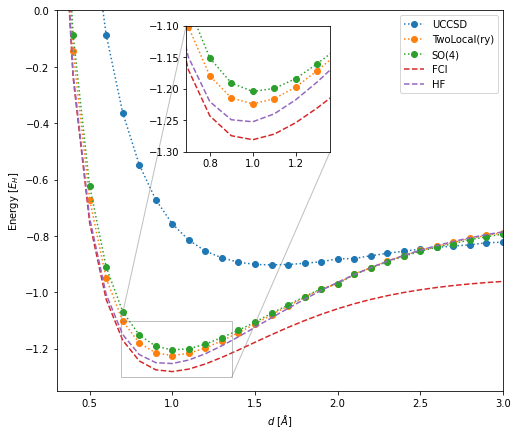

In [106]:
MIN = 0.69
MAX = 1.36

YMIN = -1.3
YMAX = -1.1

fig, ax = plt.subplots(figsize=[8, 7])

for (method,E) in energies.items():
    #if method == 'TwoLocal(ry)':
    #    plt.plot(dist,E,'bo',label=method)
    if method == 'FCI' or method =='HF':
        plt.plot(dist,E,'--',label=method)
    elif method == 'TwoLocal(ry_rz)':
         a=4
    else:
        plt.plot(dist,E,'o:',label=method)
    
plt.xlabel(r"$d$ $[\AA]$")
plt.ylabel(r"Energy $[E_H]$")
plt.legend()
plt.ylim([-1.35, +0.])
plt.xlim([0.3, 3])

sub_axes = plt.axes([.35, .6, .25, .25])     

sub_axes.axis(ymin=YMIN,ymax=YMAX)
sub_axes.axis(xmin=MIN,xmax=MAX)

for (method,E) in energies.items():
    y = []
    x = []    
    for i in range(len(E)):
        if(dist[i] >= MIN and dist[i] <= MAX):
            x.append(dist[i])
            y.append(E[i])
    
 #   if method == 'TwoLocal(ry)':
 #       sub_axes.plot(dist,E,'bo',label=method)
    if method == 'FCI' or method =='HF':
        sub_axes.plot(dist,E,'--',label=method)
    elif method == 'TwoLocal(ry_rz)':
         a=4
    else:
        sub_axes.plot(dist,E,'o:',label=method)
        #sub_axes.plot(dist,E,'')


ax.indicate_inset_zoom(sub_axes)

#plt.ylim([-1.3, .0])
#plt.xlim([0.5, 1.5])

plt.savefig('/mnt/c/Users/Rodolfo/Desktop/figura.png')
plt.show()